In [1]:
pip install tqdm

In [3]:
import zipfile
import os

# Path to your ZIP file and extraction directory
zip_path = r"C:\\Users\\USER\\Documents\\Motorq_DS_2025\\ds_assement_2026_summer_intern\\Test_Case_dataCleaning.zip"
extract_to = "unzipped_data/"

# Extract the zip file
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(extract_to)

# Check extracted contents
os.listdir(extract_to)

['Test_Case_dataCleaning.csv']

In [6]:
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm 

# Adjust to actual filename inside ZIP
csv_path = extract_to + "Test_Case_dataCleaning.csv"
df_sample = pd.read_csv(csv_path, nrows=2)
print(df_sample.columns)
df_sample.head(1)

Index(['BODY_CLEANED'], dtype='object')


,BODY_CLEANED
0,"{\n ""meta"": {\n ""messageType"": ""VehicleDat..."


In [7]:
# Testing the structure of the file
record = json.loads(df_sample["BODY_CLEANED"][0])
print(json.dumps(record, indent=2))

{
  "meta": {
    "messageType": "VehicleData",
    "pollerFetchTime": 1751725939315,
    "version": "v2"
  },
  "partitionKey": "df979dc9-5cc6-470f-a105-d3108fd03c19",
  "timestamp": "20250705143219.297",
  "transactionId": "df979dc9-5cc6-470f-a105-d3108fd03c19",
  "vinList": [
    {
      "dischargeWarning": {
        "hazardStatus": 0,
        "tailLampStatus": 0
      },
      "evStatusData": [
        {
          "attribute": "ign3Status",
          "dataType": 1,
          "value": "0"
        }
      ],
      "headLampStatus": {
        "headLamp": 0,
        "leftHighLamp": 0,
        "leftLowLamp": 0,
        "rightHighLamp": 0,
        "rightLowLamp": 0
      },
      "locationTimestamp": {
        "offSet": -7,
        "time": "20250705143213.000"
      },
      "statusData": [
        {
          "attribute": "odometer",
          "dataType": 2,
          "unit": 1,
          "value": "28082.6"
        },
        {
          "attribute": "gasLevel",
          "dataType": 1,

In [ ]:
chunksize = 50000

def extract_attributes(status_data: list) -> dict:
    return {item["attribute"]: item.get("value") for item in status_data}

# Time-stamp based Sorting - merge sort (O(n log n))
def merge_sort(arr, key_func):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left = merge_sort(arr[:mid], key_func)
    right = merge_sort(arr[mid:], key_func)

    return merge(left, right, key_func)

def merge(left, right, key_func):
    merged = []
    i = j = 0

    while i < len(left) and j < len(right):
        if key_func(left[i]) <= key_func(right[j]):
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1

    merged.extend(left[i:])
    merged.extend(right[j:])
    return merged

parsed_records = []

for chunk in tqdm(pd.read_csv(csv_path, chunksize=chunksize), desc="Reading and Parsing"):
    for _, row in chunk.iterrows():
        try:
            raw = json.loads(row["BODY_CLEANED"])
            vin_obj = raw["vinList"][0]

            # Handle missing VIN
            vin = vin_obj.get("vin")
            if not vin:
                continue

            # Check and safely extract statusTimestamp
            status_timestamp_info = vin_obj.get("statusTimestamp", {})
            status_timestamp_str = status_timestamp_info.get("time")
            if not status_timestamp_str:
                continue  # skip rows without proper timestamp

            # Check and parse pollerFetchTime
            poller_time_ms = raw["meta"].get("pollerFetchTime", None)
            if poller_time_ms is None:
                continue

            # Convert timestamps
            status_ts = datetime.strptime(status_timestamp_str, "%Y%m%d%H%M%S.%f")
            poller_ts = datetime.utcfromtimestamp(poller_time_ms / 1000.0)

            # Extract telemetry parameters
            status_values = extract_attributes(vin_obj.get("statusData", []))
            odometer = float(status_values.get("odometer", 0))
            fuel = float(status_values.get("gasLevel", 0))
            speed = float(status_values.get("speed", 0))
            ignition = status_values.get("ignStatus", "0")

            parsed_records.append({
                "VIN": vin,
                "statusTimestamp": status_ts,
                "pollerFetchTime": poller_ts,
                "odometer": odometer,
                "fuelLevel": fuel,
                "speed": speed,
                "ignitionStatus": ignition
            })

        except Exception as e:
            print(f"Skipping row due to error: {e}")


Reading and Parsing: 16it [02:58, 11.15s/it]


In [24]:
import matplotlib.pyplot as plt

# Baseline metrics
original_df = pd.DataFrame(parsed_records)
print("Total Parsed Rows:", len(original_df))
print("Sample:")
display(original_df.head(3))

Total Parsed Rows: 781941
Sample:


,VIN,statusTimestamp,pollerFetchTime,odometer,fuelLevel,speed,ignitionStatus
0,MASKEDVIN003,2025-07-05 14:32:10,2025-07-05 14:32:19.315,28082.6,24.0,0.0,1
1,MASKEDVIN003,2025-07-08 17:00:37,2025-07-08 17:00:40.672,28605.6,100.0,28.0,1
2,MASKEDVIN003,2025-07-06 18:14:14,2025-07-06 18:14:18.365,28443.6,37.0,0.0,0


In [25]:
# Task 1: Out-of-Order data
# Ideal Approach: Track latest statusTimestamp seen per VIN. Retain only chronologically increasing messages

from collections import defaultdict 

# parsed_records_sorted = sorted(parsed_records, key=lambda x: (x["VIN"], x["pollerFetchTime"])) ; using built-in

parsed_records_sorted = merge_sort(parsed_records, key_func=lambda x: (x["VIN"], x["pollerFetchTime"])) # using the manual merge sort implemented


cleaned_1 = []
latest_ts_per_vin = {}

for row in parsed_records_sorted:
    vin = row["VIN"]

    status_ts = row["statusTimestamp"]
    poller_ts = row["pollerFetchTime"]

    if vin not in latest_ts_per_vin or status_ts >= latest_ts_per_vin[vin]:
        cleaned_1.append(row)
        latest_ts_per_vin[vin] = status_ts
    
    else :
        pass #drop out-of-order

# Metrics
before = len(parsed_records)        
after = len(cleaned_1)
removed = before - after
percent_removed = (removed/before)*100

print("Task 1: Out-of-Order Timestamp Removal")
print(f"Rows Before: {before}")
print(f"Rows After: {after}")
print(f"Removed: {removed} ({percent_removed:.2f}%)")

Task 1: Out-of-Order Timestamp Removal
Rows Before: 781941
Rows After: 589594
Removed: 192347 (24.60%)


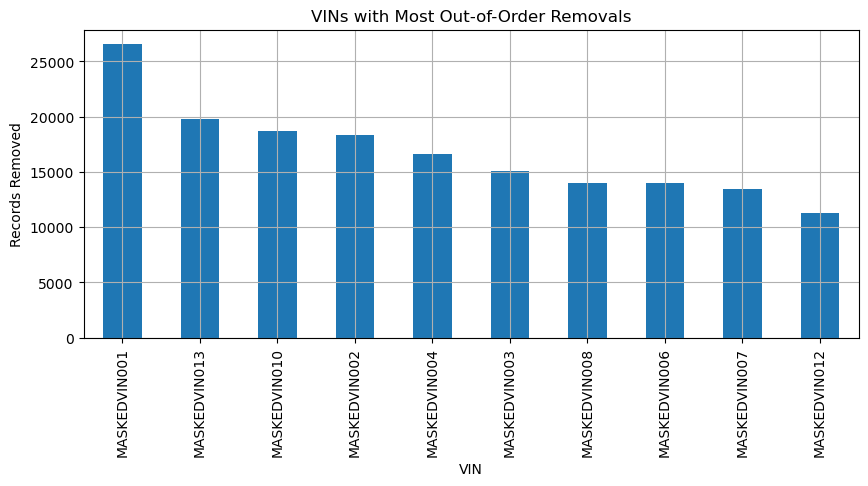

In [26]:
# Task 1 visualization
import seaborn as sns

vin_counts_before = pd.DataFrame(parsed_records).groupby("VIN").size()
vin_counts_after = pd.DataFrame(cleaned_1).groupby("VIN").size()

comparison_df = pd.DataFrame({
    "Before": vin_counts_before,
    "After": vin_counts_after
}).dropna()

comparison_df["Removed"] = comparison_df["Before"] - comparison_df["After"]

plt.figure(figsize=(10,4))
comparison_df["Removed"].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("VINs with Most Out-of-Order Removals")
plt.ylabel("Records Removed")
plt.grid()
plt.show()

In [27]:
# Task 2 : Duplicate/Conflicting messages
# Ideal Approach: Group by (VIN, statusTimestamp). Keep only record with earliest pollerFetchTime

best_by_ts = defaultdict(lambda: None)

for row in cleaned_1:
    key = (row["VIN"], row["statusTimestamp"])
    current_poll = row["pollerFetchTime"]

    if best_by_ts[key] is None or current_poll < best_by_ts[key]["pollerFetchTime"]:
        best_by_ts[key] = row

cleaned_2 = list(best_by_ts.values())

#Metrics
before = len(cleaned_1)
after = len(cleaned_2)
removed = before - after
percent_removed = (removed / before) * 100

print("Task 2: Duplicate Timestamp Resolution")
print(f"Rows Before: {before}")
print(f"Rows After: {after}")
print(f"Removed: {removed} ({percent_removed:.2f}%)")

Task 2: Duplicate Timestamp Resolution
Rows Before: 589594
Rows After: 528978
Removed: 60616 (10.28%)


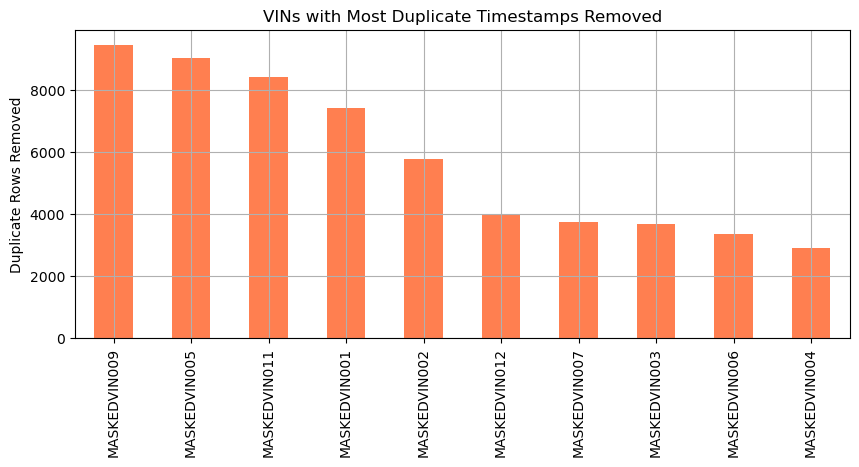

In [28]:
# Task 2 visualization
import matplotlib.pyplot as plt

df1 = pd.DataFrame(cleaned_1)
df2 = pd.DataFrame(cleaned_2)

dupe_diff = df1["VIN"].value_counts() - df2["VIN"].value_counts()
dupe_diff = dupe_diff.dropna().sort_values(ascending=False)

dupe_diff.head(10).plot(kind="bar", figsize=(10,4), color='coral')
plt.title("VINs with Most Duplicate Timestamps Removed")
plt.ylabel("Duplicate Rows Removed")
plt.grid()
plt.show()

In [29]:
# Task 3 : Odometer Anomalies
# Ideal Approach: Track last seen odometer for each VIN. Remove rows where odometer decreases

cleaned_3 = []
last_odo_per_vin = {}

for row in sorted(cleaned_2, key=lambda x: (x["VIN"], x["statusTimestamp"])):
    vin = row["VIN"]
    odo = row["odometer"]

    if vin not in last_odo_per_vin or odo >= last_odo_per_vin[vin]:
        cleaned_3.append(row)
        last_odo_per_vin[vin] = odo

#Metrics
before = len(cleaned_2)
after = len(cleaned_3)
removed = before - after
percent_removed = (removed / before) * 100

print("Task 3: Odometer Rollback Removal")
print(f"Rows Before: {before}")
print(f"Rows After: {after}")
print(f"Removed: {removed} ({percent_removed:.2f}%)")

Task 3: Odometer Rollback Removal
Rows Before: 528978
Rows After: 503523
Removed: 25455 (4.81%)


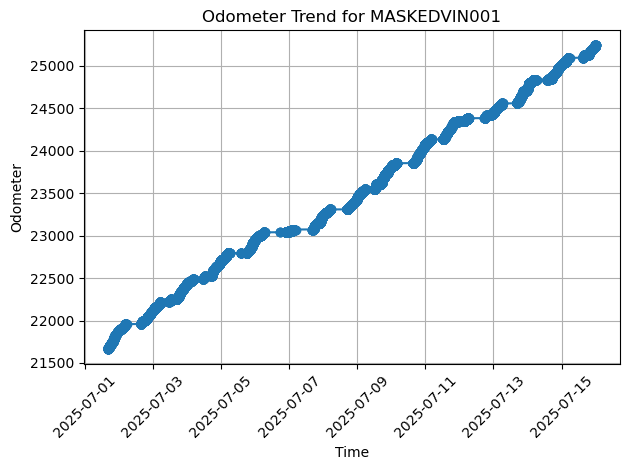

In [35]:
# Task 3 Visualization

df3 = pd.DataFrame(cleaned_3)

# Pick a sample VIN
sample_vin = df3["VIN"].value_counts().index[0]

sample_df = df3[df3["VIN"] == sample_vin].sort_values("statusTimestamp")

plt.plot(sample_df["statusTimestamp"], sample_df["odometer"], marker="o")
plt.title(f"Odometer Trend for {sample_vin}")
plt.xlabel("Time")
plt.ylabel("Odometer")
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Final export
final_df = pd.DataFrame(cleaned_3)
final_df["statusTimestamp"] = final_df["statusTimestamp"].astype(str)
final_df["pollerFetchTime"] = final_df["pollerFetchTime"].astype(str)

output_path = r"C:\\Users\\USER\\Documents\\Motorq_DS_2025\\cleaned_vehicle_data.csv"
final_df.to_csv(output_path, index=False)

print(f"Final cleaned dataset saved to : {output_path}")

Final cleaned dataset saved to : C:\\Users\\USER\\Documents\\Motorq_DS_2025\\cleaned_vehicle_data.csv
